This notebook is used to analyze the layout of genes in the UMAP 2D projection. In particular to see if neighboring genes in the genome (operons) tend to be closer to each other in the UMAP. Hinting that the analysis detects that position in the genome is linked to function / fitness profiles. 

In [1]:
import pandas as pd
from matplotlib import pyplot as plt
import numpy as np
import seaborn as sns
import tqdm
import random
import re
from scipy.stats import ks_2samp
from random import sample 


In [2]:
def umap_distance(rv_1, rv_2, df_umap):
    x1 = df_umap[df_umap.Rv_ID == rv_1].u1.values[0]
    y1 = df_umap[df_umap.Rv_ID == rv_1].u2.values[0]
    x2 = df_umap[df_umap.Rv_ID == rv_2].u1.values[0]
    y2 = df_umap[df_umap.Rv_ID == rv_2].u2.values[0]
    return np.sqrt( (x1 - x2)**2 + (y1 - y2)**2 )

In [3]:
def shuffle_genes(df_not_shuffled):
    ### shuffling of genes with respect to UMAP coordinates:
    cols_genes = df_not_shuffled.columns[:4]
    cols_umap = df_not_shuffled.columns[4:]

    df_genes = df_not_shuffled[cols_genes].copy()
    df_umap = df_not_shuffled[cols_umap].copy()

    df_genes_shuffle = df_genes.reindex(np.random.permutation(df_genes.index)).reset_index(drop = True)
    df_shuffle = pd.concat([df_genes_shuffle, df_umap], axis=1)
    
    return df_shuffle

In [4]:
df_lfc = pd.read_csv('../../data/standardized_data/df_umap_lfc_08_08_24.csv')
df_lfc.head(2)

,Rv_ID,gene_name,Annotation,func_tuberculist,COG,PE35_KO_vs_mbio_H37Rv,PPE68_KO_vs_mbio_H37Rv,Rv0950c_KO_vs_CB_WT,Rv0954_KO_vs_RJ_WT,Rv1096_KO_vs_CB_WT,...,BXD73b_vs_in_vitro_H37Rv,BXD77_vs_in_vitro_H37Rv,BXD79_vs_in_vitro_H37Rv,BXD9_vs_in_vitro_H37Rv,BXD90_vs_in_vitro_H37Rv,BXD93_vs_in_vitro_H37Rv,C57BL.6J_vs_in_vitro_H37Rv,DBA.2J_vs_in_vitro_H37Rv,u1,u2
0,Rv0001,dnaA,4.0,information pathways,L,-0.41,0.01,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,2.411358,-7.368723
1,Rv0002,dnaN,4.0,information pathways,L,3.28,2.38,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.48,0.0,0.0,0.0,2.998742,-7.274495


In [5]:
rv_1 = 'Rv0003'
rv_2 = 'Rv0007'
umap_distance(rv_1, rv_2, df_lfc)

2.7733731737287446

In [6]:
list_rv_id = df_lfc.Rv_ID.to_list()
list_rv_id = [rv for rv in list_rv_id if 'Rvnr' not in rv]
list_int_rv_id = [int(re.split( 'c|A|B|D|X' , rv.split('Rv')[1] )[0]) for rv in list_rv_id]

In [7]:
window_size = 1

In [8]:
list_pairs = [(list_rv_id[i], list_rv_id[j]) for i in range(len(list_rv_id)) for j in range(i+1,len(list_rv_id)) 
 if np.abs(list_int_rv_id[i] - list_int_rv_id[j]) <= window_size]

In [9]:
len( list_pairs )

4353

In [10]:
list_dist = []
for rv_pair in tqdm.tqdm(list_pairs):
    list_dist.append(umap_distance( rv_pair[0], rv_pair[1], df_lfc))

100%|██████████████████████████████████████| 4353/4353 [00:15<00:00, 278.37it/s]


Distances between random pairs of genes: 

In [11]:
# num_iter = len(list_pairs)
num_iter = len( list_pairs )
list_dist_rand = []
for i in range(num_iter):
    rvid_pair = random.sample(list_rv_id, 2)
    list_dist_rand.append(umap_distance( rvid_pair[0], rvid_pair[1], df_lfc))

In [12]:
len( list_dist_rand )

4353

cumulative distribution:

In [13]:
xrange = np.arange(0, 20, 0.01)
cum_list_dist = []
cum_list_dist_rand = []

for x in xrange:
    num_d = [d for d in list_dist if d <= x]
    norm_d = len(num_d) / len(list_dist)
    cum_list_dist.append(norm_d)
    
    num_d_rand = [d for d in list_dist_rand if d <= x]
    norm_d_rand = len(num_d_rand) / len(list_dist_rand)
    cum_list_dist_rand.append(norm_d_rand)

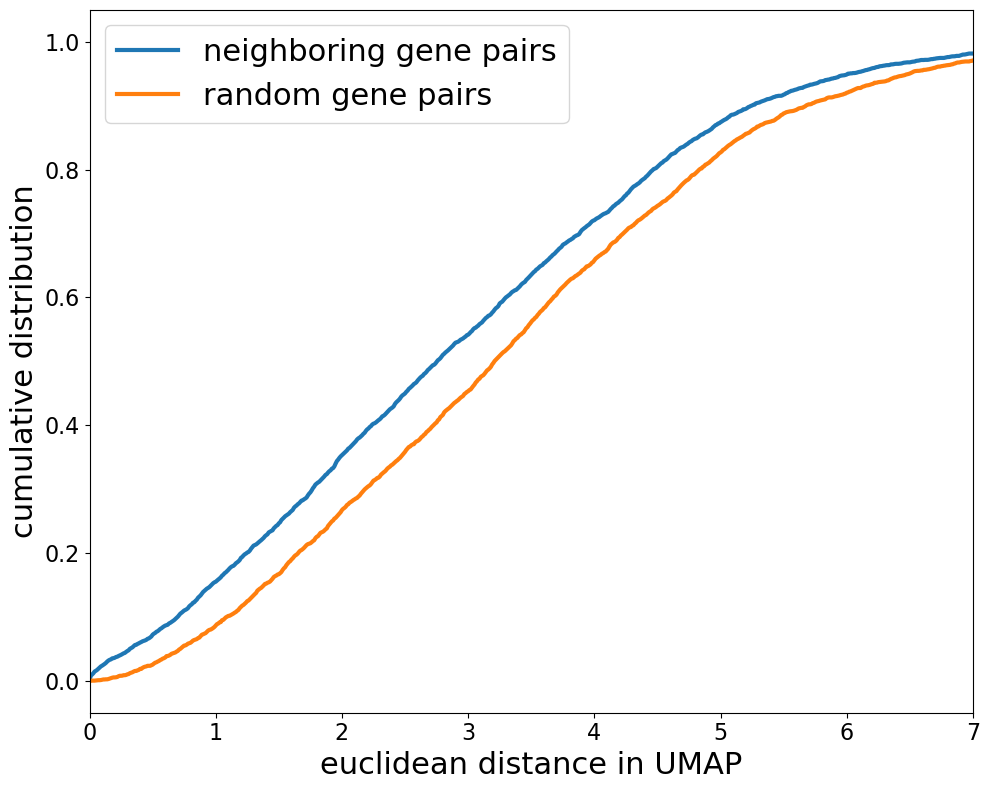

In [14]:
plt.figure(figsize = (10,8))
plt.plot(xrange, cum_list_dist, lw = 3)
plt.plot(xrange, cum_list_dist_rand, lw = 3)
plt.xlabel('euclidean distance in UMAP', fontsize = 22)
plt.ylabel('cumulative distribution', fontsize = 22)
plt.xticks(fontsize = 16)
yt = plt.yticks(fontsize = 16)
lgn=plt.legend(['neighboring gene pairs', 'random gene pairs'], fontsize = 22)
plt.xlim(0, 7)
plt.tight_layout()
plt.savefig('../../figures/pairwise_distances/umap_vs_genome_cumulative_w3_08_13_24.png', dpi=300)

In [15]:
ks_2samp(list_dist, list_dist_rand)

KstestResult(statistic=0.09648518263266713, pvalue=4.7467857384666945e-18, statistic_location=2.683278862864403, statistic_sign=1)

In [16]:
size = 2000
list_dist_subsamp = sample( list_dist, size )
ks_2samp(list_dist, list_dist_subsamp)

KstestResult(statistic=0.028413163335630598, pvalue=0.2134062961662916, statistic_location=3.1812460740779214, statistic_sign=-1)

histogram:

/var/folders/sq/kj1n2y_j4pv65q7dx21yt4h40000gn/T/ipykernel_91976/1662959150.py:2: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(list_dist, kde = False,  hist_kws=dict(edgecolor="k", linewidth=3))
/var/folders/sq/kj1n2y_j4pv65q7dx21yt4h40000gn/T/ipykernel_91976/1662959150.py:3: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad637

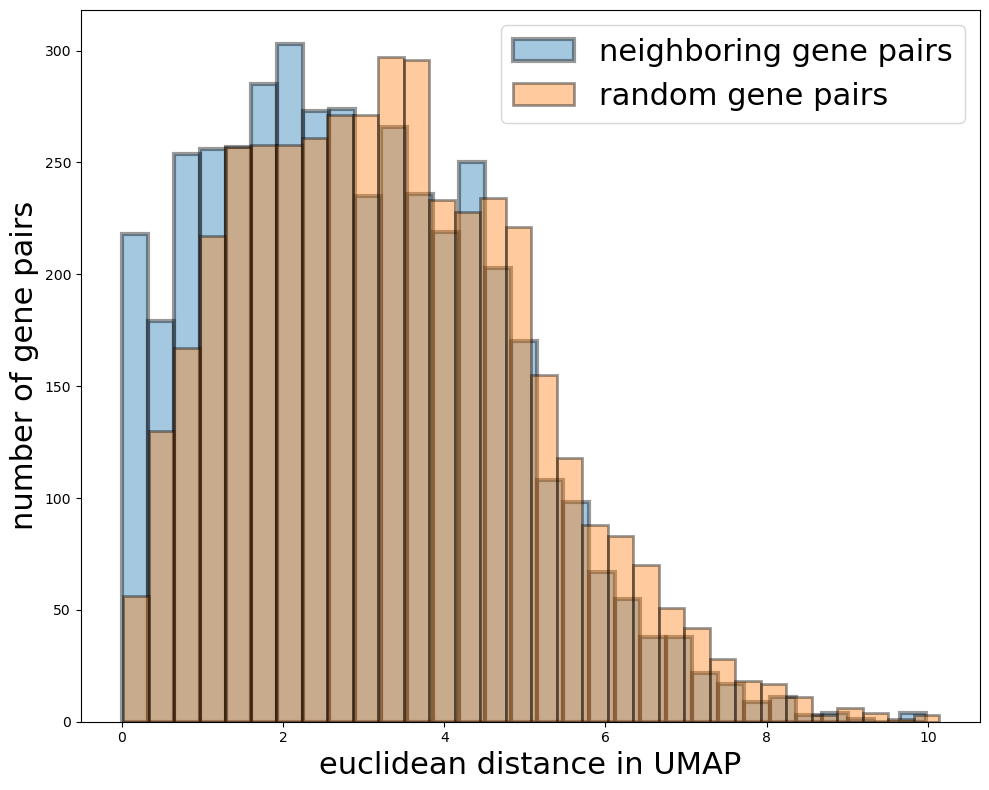

In [17]:
plt.figure(figsize = (10,8))
sns.distplot(list_dist, kde = False,  hist_kws=dict(edgecolor="k", linewidth=3))
sns.distplot(list_dist_rand, kde = False,  hist_kws=dict(edgecolor="k", linewidth=2))

plt.legend(['neighboring gene pairs', 'random gene pairs'], fontsize = 22)
plt.xlabel('euclidean distance in UMAP', fontsize = 22)
plt.ylabel('number of gene pairs', fontsize = 22)

plt.tight_layout()
# plt.savefig('../../figures/pairwise_distances/umap_vs_genome_w3.png', dpi=300)

In [18]:
ks_2samp(list_dist, list_dist_rand)

KstestResult(statistic=0.09648518263266713, pvalue=4.7467857384666945e-18, statistic_location=2.683278862864403, statistic_sign=1)

### Compare to shuffled data:

In [19]:
df_shuffled = shuffle_genes(df)

NameError: name 'df' is not defined

In [ ]:
list_dist_shuffled = []
for rv_pair in tqdm.tqdm(list_pairs):
    list_dist_shuffled.append(umap_distance( rv_pair[0], rv_pair[1], df_shuffled))

In [20]:
plt.figure(figsize = (16,6))
sns.distplot(list_dist_shuffled, kde = False,  hist_kws=dict(edgecolor="k", linewidth=3))
sns.distplot(list_dist_rand, kde = False,  hist_kws=dict(edgecolor="k", linewidth=2))
plt.legend(['neighboring gene pairs', 'random gene pairs'], fontsize = 22)
plt.xlabel('euclidean distance in UMAP', fontsize = 22)
plt.ylabel('fraction of gene pairs', fontsize = 22)
plt.savefig('../../figures/pairwise_distances/umap_vs_genome_w3_RAND.png', dpi=300)

NameError: name 'list_dist_shuffled' is not defined

<Figure size 1600x600 with 0 Axes>

In [21]:
ks_2samp(list_dist_shuffled, list_dist_rand)

NameError: name 'list_dist_shuffled' is not defined